# Statistical Learning and Deep Learning, Fall 2024 HW2
B11705009 An-Che, Liang

## Part1: Logistic Regression: Probability, Loss, Gradient, and Weights

In [1]:
import pickle

filepath = 'adult_m50kv2.pickle'
with open(filepath, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
adult50kp.keys()

dict_keys(['x_train', 'y_train', 'x_test', 'y_test', 'columnname', 'num_col', 'x_subtrain', 'x_subvalid', 'y_subtrain', 'y_subvalid', 'x_subtrain_ib', 'y_subtrain_ib'])

### (1-a) Predict probability function

In [2]:
import numpy as np


def pred_prob(X, intercept, coefs, twocol=True):
    linear_combination = X @ coefs + intercept
    prob_pos = 1 / (1 + np.exp(-linear_combination))

    if twocol:
        prob_neg = 1 - prob_pos
        return np.column_stack((prob_neg, prob_pos))
    else:
        return prob_pos.reshape(-1, 1)

### (1-b) Loss function with L2 Regularization 

In [3]:
def lr_logloss(Xtrain, ytrain, intercept, coefs, C):
    prob = pred_prob(Xtrain, intercept, coefs, twocol=False)
    prob = prob.flatten()  # convert to 1D array
    
    # compute log loss
    log_loss = -np.mean(ytrain * np.log(prob) + (1 - ytrain) * np.log(1 - prob))
    
    # compute regularization term, but exclude the intercept term
    regularization = (1 / (2 * C)) * np.sum(coefs ** 2)
    
    # compute total loss
    total_loss = log_loss + regularization
    return total_loss

### (1-c) Model training

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


lr_model = LogisticRegression(penalty='l2', C=1.0)
lr_model.fit(adult50kp['x_subtrain'], adult50kp['y_subtrain'])

# Print the model's parameters, to the precision of 4 decimal places
print("Intercept:", round(lr_model.intercept_[0], 4))
print("Coefficients:")
for col_name, coef in zip(adult50kp['columnname'], lr_model.coef_[0]):
    print(f"  {col_name}: {round(coef, 4)}")

Intercept: -1.5029
Coefficients:
  capital-loss: 0.2566
  hours-per-week: 0.3527
  capital-gain: 2.3682
  educational-num: 0.693
  age: 0.3386
  fnlwgt: 0.081
  relationship_Husband: -0.1697
  relationship_Not-in-family: -0.053
  relationship_Other-relative: -0.7189
  relationship_Own-child: -1.1709
  relationship_Unmarried: -0.1586
  relationship_Wife: 1.197
  race_Amer-Indian-Eskimo: -0.578
  race_Asian-Pac-Islander: 0.1654
  race_Black: -0.2165
  race_Other: -0.384
  race_White: -0.061
  gender_Female: -0.9933
  gender_Male: -0.0808
  occupation_Adm-clerical: 0.028
  occupation_Craft-repair: 0.0731
  occupation_Exec-managerial: 0.8506
  occupation_Farming-fishing: -0.9402
  occupation_Handlers-cleaners: -0.6231
  occupation_Machine-op-inspct: -0.2472
  occupation_Other-service: -0.7641
  occupation_Priv-house-serv: -1.3187
  occupation_Prof-specialty: 0.5347
  occupation_Protective-serv: 0.5454
  occupation_Sales: 0.3309
  occupation_Tech-support: 0.7092
  occupation_Transport-movin

In [5]:
# Evaluete on the testing set
y_test_pred = lr_model.predict(adult50kp['x_test'])

# Compute evaluation metrics
accuracy = accuracy_score(adult50kp['y_test'], y_test_pred)
recall = recall_score(adult50kp['y_test'], y_test_pred)
precision = precision_score(adult50kp['y_test'], y_test_pred)
f1 = f1_score(adult50kp['y_test'], y_test_pred)
print("Test Set Evaluation Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  F1: {f1:.4f}")

Test Set Evaluation Metrics:
  Accuracy: 0.8479
  Recall: 0.6054
  Precision: 0.7296
  F1: 0.6617


### (1-d) Loss function visualization

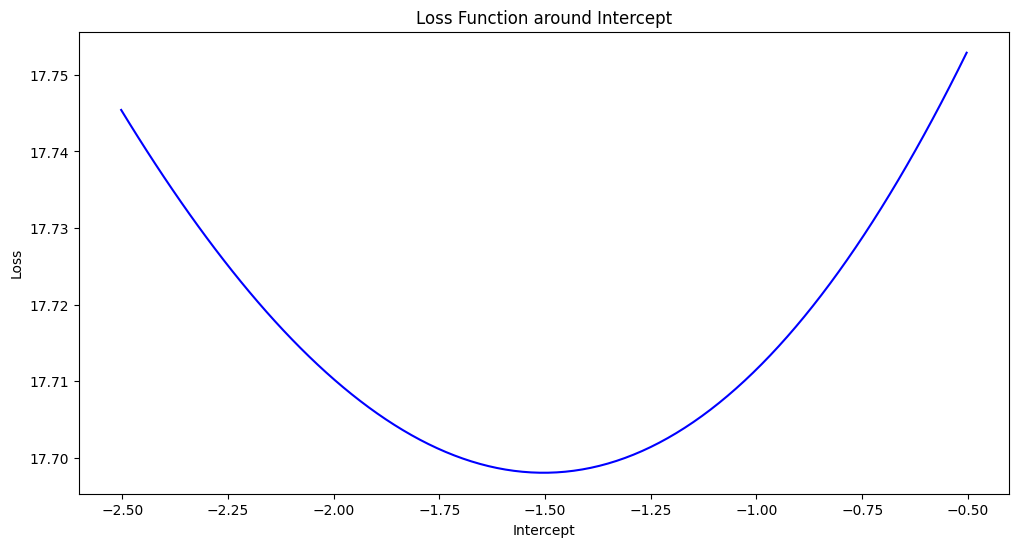

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# get the intercept and coefficients
intercept = lr_model.intercept_[0]
coefs = lr_model.coef_[0].copy()

# plot the loss function around the intercept
intercept_range = np.linspace(intercept - 1, intercept + 1, 100)
loss_intercept = [
    lr_logloss(adult50kp['x_subtrain'], adult50kp['y_subtrain'], i, coefs, C=1.0)
    for i in intercept_range
]

plt.figure(figsize=(12, 6))
plt.plot(intercept_range, loss_intercept, color="b")
plt.xlabel("Intercept")
plt.ylabel("Loss")
plt.title("Loss Function around Intercept")
plt.show()

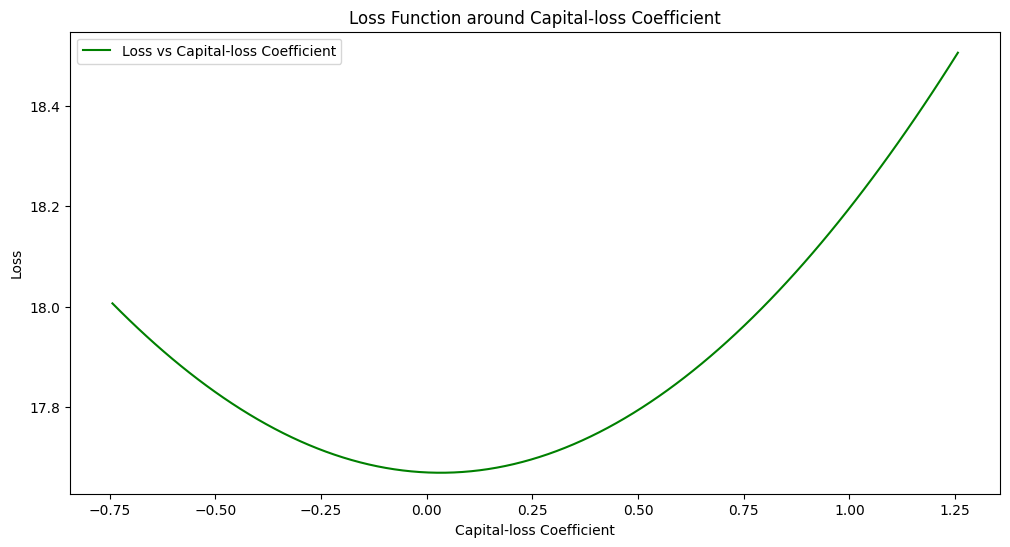

In [7]:
# find the index of the capital-loss coefficient
capital_loss_idx = list(adult50kp['columnname']).index('capital-loss')
coef_range = np.linspace(coefs[capital_loss_idx] - 1, coefs[capital_loss_idx] + 1, 100)
loss_coef = []

# plot the loss function around the capital-loss coefficient
for coef in coef_range:
    coefs_temp = coefs.copy()
    coefs_temp[capital_loss_idx] = coef
    loss = lr_logloss(adult50kp['x_subtrain'], adult50kp['y_subtrain'], intercept, coefs_temp, C=1.0)
    loss_coef.append(loss)

plt.figure(figsize=(12, 6))
plt.plot(coef_range, loss_coef, label="Loss vs Capital-loss Coefficient", color="g")
plt.xlabel("Capital-loss Coefficient")
plt.ylabel("Loss")
plt.title("Loss Function around Capital-loss Coefficient")
plt.legend()
plt.show()

## Part2: Chi-Squared Feature Selection

In [8]:
import numpy as np
import pandas as pd

def my_chi2_fs(X, y):
    # store the chi2 statistics for each feature
    chi2_stats = []
    
    for column in X.columns:
        contingency_table = pd.crosstab(X[column], y)
        observed = contingency_table.values
        # calculate the expected values
        col_sum = observed.sum(axis=0)
        row_sum = observed.sum(axis=1)
        total = observed.sum()
        expected = np.outer(row_sum, col_sum) / total
        # calculate the chi2 statistic
        chi2 = np.sum((observed - expected) ** 2 / expected)
        chi2_stats.append(chi2)
    
    # return the chi2 statistics
    return np.array(chi2_stats)

In [9]:
import pickle
dsfile = "mbav1.pickle"
with open(dsfile, "rb") as fh1:
    mba = pickle.load(fh1)

# get the categorical columns
catcol = mba['x_train'].select_dtypes('object').columns
x_traincat = mba['x_train'][catcol].copy()

# compute the chi2 statistics
chi2vec = my_chi2_fs(x_traincat, mba['y_train'])

# print the chi2 statistics
for i, acol in enumerate(x_traincat.columns):
    print(f"{acol:20s} {chi2vec[i]:.4f}")

gender               0.1106
major                4.1315
race                 0.9505
work_industry        16.3957


## Part3: Forward Feature Selection

### (3-a) Count features

In [10]:
import pickle


dsfile = 'adult_m50kv2.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)


x_subtrain = adult50kp['x_subtrain']
y_subtrain = adult50kp['y_subtrain']
x_subvalid = adult50kp['x_subvalid']
y_subvalid = adult50kp['y_subvalid']
x_test = adult50kp['x_test']
y_test = adult50kp['y_test']


n_train = x_subtrain.shape[0]
n_valid = x_subvalid.shape[0]
n_test = x_test.shape[0]
n_features = x_subtrain.shape[1]

# print the number of features and data points in each set
print(f"Features: {n_features}")
print(f"Training data: {n_train}")
print(f"Validation data: {n_valid}")
print(f"Test data: {n_test}")


Features: 102
Training data: 27000
Validation data: 3162
Test data: 15060


### (3-b) Train the model and calcaulate F1 score

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Train a logistic regression model
model = LogisticRegression(solver='lbfgs', C=1000, max_iter=1000, tol=1e-5)
model.fit(x_subtrain, y_subtrain)

# Calculate the F1 score on the validation set
y_valid_pred = model.predict(x_subvalid)
y_test_pred = model.predict(x_test)

f1_valid_full = f1_score(y_subvalid, y_valid_pred)
f1_test_full = f1_score(y_test, y_test_pred)

print(f"Validation F1 Score (all features): {f1_valid_full:.4f}")
print(f"Test F1 Score (all features): {f1_test_full:.4f}")


Validation F1 Score (all features): 0.6685
Test F1 Score (all features): 0.6623


### (3-c) Foward feature selection

In [16]:
selected_features = []
best_f1_valid = 0
improved = True
num_features = x_subtrain.shape[1]

while improved:
    improved = False
    best_feature = None
    best_f1 = best_f1_valid
    
    for feature_index in range(num_features):
        if feature_index in selected_features:
            continue

        # Construct a temporary feature set with selected features plus the new feature index
        features_to_test = selected_features + [feature_index]
        x_train_temp = x_subtrain[:, features_to_test]
        x_valid_temp = x_subvalid[:, features_to_test]
        
        # Train model
        model = LogisticRegression(solver='lbfgs', C=1000, max_iter=1000, tol=1e-5)
        model.fit(x_train_temp, y_subtrain)
        
        # Calculate validation F1 Score
        y_valid_pred = model.predict(x_valid_temp)
        f1_valid = f1_score(y_subvalid, y_valid_pred)
        
        # Update if F1 Score improves
        if f1_valid > best_f1:
            best_f1 = f1_valid
            best_feature = feature_index
            improved = True
    
    # Add the best feature to selected_features if there was an improvement
    if improved:
        selected_features.append(best_feature)
        best_f1_valid = best_f1
        print(f"Selected Feature Index: {best_feature}, Validation F1 Score: {best_f1_valid:.4f}")

# Final selected features will be a list of feature indices


# Train the final model on the selected features
# Final selected features
x_train_selected = x_subtrain[:, selected_features]  # Shape should be (num_samples, num_selected_features)
x_test_selected = x_test[:, selected_features]

# Verify the shape consistency
print(f"x_train_selected shape: {x_train_selected.shape}")
print(f"y_subtrain shape: {y_subtrain.shape}")
print(f"x_test_selected shape: {x_test_selected.shape}")
print(f"y_test shape: {y_test.shape}")

# Train the final model with the selected features
model_final = LogisticRegression(solver='lbfgs', C=1000, max_iter=1000, tol=1e-5)
model_final.fit(x_train_selected, y_subtrain)

# Make predictions and calculate F1 score on the test set
y_test_pred_final = model_final.predict(x_test_selected)
f1_test_final = f1_score(y_test, y_test_pred_final)

print("\nFinal Selected Features Indices:", selected_features)
print(f"Test F1 Score (selected features): {f1_test_final:.4f}")


Selected Feature Index: 3, Validation F1 Score: 0.3205
Selected Feature Index: 97, Validation F1 Score: 0.5532
Selected Feature Index: 2, Validation F1 Score: 0.6263
Selected Feature Index: 21, Validation F1 Score: 0.6429
Selected Feature Index: 0, Validation F1 Score: 0.6546
Selected Feature Index: 25, Validation F1 Score: 0.6573
Selected Feature Index: 24, Validation F1 Score: 0.6611
Selected Feature Index: 19, Validation F1 Score: 0.6644
Selected Feature Index: 81, Validation F1 Score: 0.6653
Selected Feature Index: 30, Validation F1 Score: 0.6662
Selected Feature Index: 9, Validation F1 Score: 0.6676
Selected Feature Index: 8, Validation F1 Score: 0.6680
Selected Feature Index: 7, Validation F1 Score: 0.6685
Selected Feature Index: 69, Validation F1 Score: 0.6690
x_train_selected shape: (27000, 14)
y_subtrain shape: (27000,)
x_test_selected shape: (15060, 14)
y_test shape: (15060,)

Final Selected Features Indices: [3, 97, 2, 21, 0, 25, 24, 19, 81, 30, 9, 8, 7, 69]
Test F1 Score (s

### (3-d) Discussion

In [17]:
# Assuming 'columnname' contains the feature names as given in the dataset
feature_names = adult50kp['columnname']  # List of all feature names in the original dataset
selected_feature_names = [feature_names[i] for i in selected_features]  # Get names of selected features

print("Selected Features and their indices:")
for idx, feature in zip(selected_features, selected_feature_names):
    print(f"Feature Index: {idx}, Feature Name: {feature}")


Selected Features and their indices:
Feature Index: 3, Feature Name: educational-num
Feature Index: 97, Feature Name: marital-status_Married-civ-spouse
Feature Index: 2, Feature Name: capital-gain
Feature Index: 21, Feature Name: occupation_Exec-managerial
Feature Index: 0, Feature Name: capital-loss
Feature Index: 25, Feature Name: occupation_Other-service
Feature Index: 24, Feature Name: occupation_Machine-op-inspct
Feature Index: 19, Feature Name: occupation_Adm-clerical
Feature Index: 81, Feature Name: native-country_South
Feature Index: 30, Feature Name: occupation_Tech-support
Feature Index: 9, Feature Name: relationship_Own-child
Feature Index: 8, Feature Name: relationship_Other-relative
Feature Index: 7, Feature Name: relationship_Not-in-family
Feature Index: 69, Feature Name: native-country_Jamaica


The features selected during Forward Feature Selection indicate the most influential variables in predicting income from the dataset. Here’s an explanation of each feature's potential significance:

1. **`educational-num`**: This variable typically represents the years of education an individual has completed. Education level is a strong predictor of income since higher educational attainment often correlates with higher-paying jobs and better employment opportunities.

2. **`marital-status_Married-civ-spouse`**: Marital status, specifically being married to a civilian spouse, can impact income as it often correlates with household income levels, stability, and potentially combined income benefits.

3. **`capital-gain`**: Capital gains represent income from investments and are generally associated with higher income brackets, as individuals with significant capital gains typically have more wealth.

Overall, these features suggest that education, job type, financial assets, and family or relationship structure are influential in predicting income level, aligning with socioeconomic factors that commonly affect earnings. This selection aligns well with expectations in socioeconomic studies, where education, occupation, financial activities, and family roles are major determinants of income. 

